## Learning about beers and breweries

For this exploration we will be using two datasets: 
1. Beer reviews from BeerAdvocate (https://www.beeradvocate.com/). this dataset spans a period of more than 10 years, including ~1.5 million reviews up to November 2011. Each review includes ratings in terms of five "aspects": appearance, aroma, palate, taste, and overall impression.
2. A list of breweries from XXXXXX - we need this dataset because the reviews dataset does not include locations of breweries.  

We will answer the six following questions:
1. Which brewery produces the strongest beers by ABV % ?
2. Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?
3. if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?
4. Where are the strongest beers being brewed?
5. Where are the best beers being brewed?
6. Are the most commonly reviewed beer styles good or bad?


In [1]:
### import libraries

%matplotlib inline
import pandoc
import pandas as pd
import numpy as np
import re
import csv
import seaborn as sn
from matplotlib import pyplot as plt

This is a glance of the first dataset.

In [2]:
reviews = pd.read_csv("beer_reviews.csv")
reviews[:5]



,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


#### let's check for the number of unique values in each column

####  there are reviews for 104 different beer styles and 56857 beers!
#### also, We can see that there are more brewery ID's than names, probably because some breweries have multiple locations.




In [3]:
print("Unique Values in each column:")
for col in reviews:
    a = len(reviews[col].unique())
    print(col + " " + str(a))

Unique Values in each column:
brewery_id 5840
brewery_name 5743
review_time 1577960
review_overall 10
review_aroma 9
review_appearance 10
review_profilename 33388
beer_style 104
review_palate 9
review_taste 9
beer_name 56857
beer_abv 531
beer_beerid 66055


In [4]:
### let's check for NaN's

reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [5]:
## let's create a version with no NaN's
full_reviews = reviews.dropna()
print("no missing values:")
for i in full_reviews:
    print(i + " " + str(full_reviews[i].isnull().sum()))

no missing values:
brewery_id 0
brewery_name 0
review_time 0
review_overall 0
review_aroma 0
review_appearance 0
review_profilename 0
beer_style 0
review_palate 0
review_taste 0
beer_name 0
beer_abv 0
beer_beerid 0


In [6]:
### some properties of the data

pd.set_option('display.float_format', lambda x: '%.2f' % x) ### supress scientific notation 


full_reviews.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3074.31,1225331511.85,3.82,3.75,3.85,3.75,3.80,7.04,21405.75
std,5544.34,75834546.41,0.72,0.70,0.61,0.68,0.73,2.32,21780.33
min,1.00,840672001.00,0.00,1.00,0.00,1.00,1.00,0.01,5.00
25%,141.00,1175562133.00,3.50,3.50,3.50,3.50,3.50,5.20,1654.00
50%,417.00,1240355793.00,4.00,4.00,4.00,4.00,4.00,6.50,12830.00
75%,2298.00,1289085828.75,4.50,4.00,4.00,4.00,4.50,8.50,39236.00
max,28003.00,1326285348.00,5.00,5.00,5.00,5.00,5.00,57.70,77316.00


In [7]:

full_reviews.shape

(1518478, 13)

### Which brewery produces the strongest beers by ABV%?

In [8]:
grouped_brew = full_reviews.groupby('brewery_name')
means = grouped_brew.agg(np.mean)
highest_abv = means.loc[:, 'beer_abv'].sort_values(ascending=False)
print(highest_abv.head(10))


brewery_name
Schorschbräu                                          19.23
Shoes Brewery                                         15.20
Rome Brewing Company                                  13.84
Hurlimann Brewery                                     13.75
Alt-Oberurseler Brauhaus                              13.20
Rascal Creek Brewing Co.                              13.00
Monks Porter House                                    12.47
Brasserie Grain d' Orge (Brasserie Jeanne d'Arc SA)   12.45
Tugboat Brewing Company                               12.19
United Brands Company                                 12.00
Name: beer_abv, dtype: float64


Schorschbräu brewery is the highest, with an ABV average of 19.22. you can read about them here - http://www.schorschbraeu.de/

Let's see which beers the three top ABV breweries produce?

In [9]:
highest = full_reviews[full_reviews['brewery_name'].isin(["Schorschbräu", "Shoes Brewery", "Rome Brewing Company"])]
a = highest[['brewery_name', 'beer_name', 'beer_style', "beer_abv"]].drop_duplicates()
a.style.bar(subset=['beer_abv'], color='#d65f5f')

### Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?

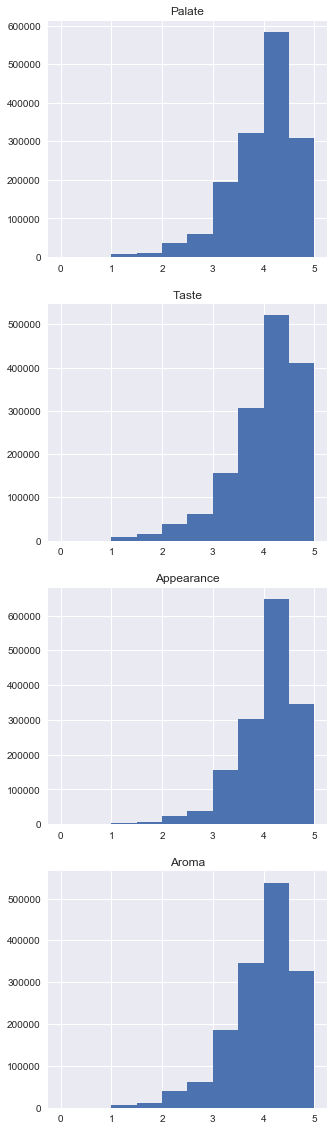

In [10]:
# first let's see the distributions of the four factors

fig = plt.figure(figsize=(5,20))
ax1 = fig.add_subplot(4,1,1)

ax1.hist(full_reviews['review_palate'], range=(0, 5)) 
plt.title("Palate") 

ax2 = fig.add_subplot(4,1,2)
ax2.hist(full_reviews['review_taste'], range=(0, 5))
plt.title("Taste")

ax3 = fig.add_subplot(4,1,3)
ax3.hist(full_reviews['review_appearance'], range=(0, 5))
plt.title("Appearance")

ax4 = fig.add_subplot(4,1,4)
ax4.hist(full_reviews['review_aroma'], range=(0, 5))
plt.title("Aroma")

plt.show()


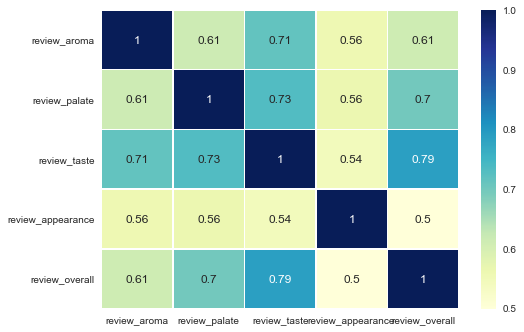

In [11]:

# now let's check the correlations of the factors with the overall review: 

factors = full_reviews[['review_aroma', 'review_palate', 'review_taste', 'review_appearance', 'review_overall']]
cor = factors.corr()
sn.heatmap(cor, annot=True, linewidths=.5, cmap="YlGnBu")

#### Taste is the highest correlated factor with overall review (0.79), and palate is second (0.7).
#### All factors are correlated as well. let's see if the taste-overall review correlation is significant. 




In [12]:
from scipy.stats import pearsonr

pvalue = pearsonr(full_reviews['review_taste'], full_reviews['review_overall'])[1]
print(pvalue)
### yes, obviously it is significant. 

0.0


### if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?

In [13]:
## let's create a score which is the average of aroma and appearance. we can use the original data because there
## are no missing values in those columns.

reviews['aroma_appear'] = (reviews['review_appearance'] + reviews['review_aroma']) / 2

grouped = reviews.groupby(reviews['beer_style'])
best_aroma_appear = grouped.agg(np.mean).loc[:, 'aroma_appear'].sort_values(ascending=False)

print("Top 5 beer styles, aroma and appearance wise")
best_aroma_appear.head()

Top 5 beer styles, aroma and appearance wise


beer_style
American Double / Imperial Stout   4.16
Russian Imperial Stout             4.14
Quadrupel (Quad)                   4.13
American Double / Imperial IPA     4.09
Gueuze                             4.08
Name: aroma_appear, dtype: float64

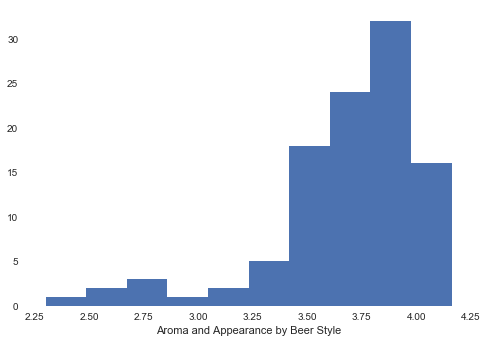

In [14]:
sn.set_style("white")
plt.hist(best_aroma_appear, bins=None)
plt.xlabel("Aroma and Appearance by Beer Style")
sn.despine(left=True, bottom=True)

## Where are the strongest beers being brewed?
#### Unfortunately, the beer reviews dataset does not contain breweries' locations. so, we will use a second dataset, from XXXXXX which will be merged with the first one. let's have a look at it.  

In [15]:
brew = pd.read_csv("breweries.csv", delimiter=";", error_bad_lines=False, quoting=csv.QUOTE_NONE, encoding='utf-8', warn_bad_lines=False)
### drop all rows with no brewery or country name: 

brew = brew.dropna(subset=['breweries', 'country'])

brew.shape

(1405, 14)

In [16]:
brew.describe()

,id,breweries,address1,address2,city,state,code,country,phone,website,filepath,descript,last_mod,"coordinates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
count,1405,1405,1136,4,1384,1225,770,1405,1091,468,14,227,1397,1397
unique,1397,1395,1122,4,978,165,644,62,1081,461,14,208,21,1258
top,598,Capital City Brewing Company,10426 East Jomax Road,1000 Murray Ross Parkway,Portland,California,0,United States,(812)325-93-25,http://www.wernesgruener.de/,echigo.png,(No longer brewing),2010-07-22T23:00:20+03:00,",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
freq,2,2,2,1,17,129,40,870,2,2,1,17,1377,96


In [17]:
### so, we have 1405 breweries and country names in the dataset. this is how it looks like

brew.head()

,id,breweries,address1,address2,city,state,code,country,phone,website,filepath,descript,last_mod,"coordinates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
0,9,Aberdeen Brewing,210 Aberdeen Dr.,NaN,Valparaiso,Indiana,NaN,United States,(219) 548-3300,NaN,NaN,NaN,2010-07-22T23:00:20+03:00,"41.4392,-87.1078,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
1,10,Abita Brewing Company,PO Box 1510,NaN,Abita Springs,Louisiana,70420,United States,800-737-2311,http://www.abita.com/,NaN,"Founded in 1986, the Abita Brewing Company is ...",2010-07-22T23:00:20+03:00,"30.5049,-89.944,,,,,,,,,,,,,,,,,"
2,19,Aldaris,Tvaika iela 44,NaN,Rga,NaN,NaN,Latvia,371-70-23-200,NaN,NaN,NaN,2010-07-22T23:00:20+03:00,",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
3,21,AleSmith Brewing,9368 Cabot Drive,NaN,San Diego,California,92126,United States,1-858-549-9888,http://alesmith.com/,NaN,NaN,2010-07-22T23:00:20+03:00,"32.892,-117.144,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
4,31,Alvinne Picobrouwerij,Oostrozebekestraat 114,NaN,Ingelmunster,West-Vlaanderen,NaN,Belgium,32-051-/-30-55-17,NaN,NaN,NaN,2010-07-22T23:00:20+03:00,"50.919,3.2632,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"


In [18]:
### are they all unique? no, there are 10 duplicates, probably because of multiple locations. let's get rid of them. 
len(brew['breweries'].unique())
brew = brew.drop_duplicates(subset=['breweries'])
brew.describe()

,id,breweries,address1,address2,city,state,code,country,phone,website,filepath,descript,last_mod,"coordinates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
count,1395,1395,1129,4,1374,1217,764,1395,1084,466,13,224,1388,1388
unique,1395,1395,1122,4,978,165,644,62,1081,461,13,208,20,1250
top,519,Unibroue,155 Mata Way Suite 104,1000 Murray Ross Parkway,Portland,California,0,United States,0032 14699800,http://www.wernesgruener.de/,echigo.png,(No longer brewing),2010-07-22T23:00:20+03:00,",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
freq,1,1,2,1,17,127,39,864,2,2,1,17,1369,95


In [19]:
uniq = reviews['brewery_name'].unique()
print("there are " + str(len(uniq)) + " unique breweries in the reviews dataset.")

there are 5743 unique breweries in the reviews dataset.


In [20]:
def check(x):
    
    if x in uniq:
        return True
    else:
        return False

a = brew['breweries'].apply(check)

In [21]:
print(str(a.sum()) + " Breweries appear on both datasets")

319 Breweries appear on both datasets


In [22]:
print()

In [23]:
combined = pd.merge(reviews, brew, left_on='brewery_name', right_on='breweries',
      how='inner', sort=False)

In [24]:
print("The new reviews dataset, with brewery locations, has " + str(combined.shape[0]) + " reviews, while the old one had " + str(reviews.shape[0]))

The new reviews dataset, with brewery locations, has 451856 reviews, while the old one had 1586614


In [25]:
combined.columns.values

array(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename',
       'beer_style', 'review_palate', 'review_taste', 'beer_name',
       'beer_abv', 'beer_beerid', 'aroma_appear', 'id', 'breweries',
       'address1', 'address2', 'city', 'state', 'code', 'country', 'phone',
       'website', 'filepath', 'descript', 'last_mod',
       'coordinates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'], dtype=object)

In [26]:
### which are the most frequent manufacturing countries? (in percents)

print(str(combined.loc[:, "country"].value_counts(normalize=True)[:10]) + "\n\n" + "_"*40 + "\n\n 79 percent of reviews are of american beers.")


United States    0.79
Belgium          0.07
United Kingdom   0.05
Canada           0.04
Germany          0.03
Russia           0.00
France           0.00
Ireland          0.00
New Zealand      0.00
Austria          0.00
Name: country, dtype: float64

________________________________________

 79 percent of reviews are of american beers.


In [27]:
country_abv = combined.loc[:, ['country', 'beer_abv']].dropna()

In [28]:
abv_by_country = country_abv.groupby('country').agg(np.mean).sort_values('beer_abv', ascending=False)
abv_by_country.style.bar(subset=['beer_abv'], color='#b22222')

### On average, polish beer are the strongest - with 8.96% alcohol.

## Which countries have the best beers, based on each of the four factors?

In [29]:
country_factors = combined.loc[:, ['country','review_overall', 'review_aroma', 'review_palate', 'review_taste', 'review_aroma']].dropna()

In [30]:
factors_by_country = country_factors.groupby('country').agg(np.mean).sort_values('review_overall', ascending=False)

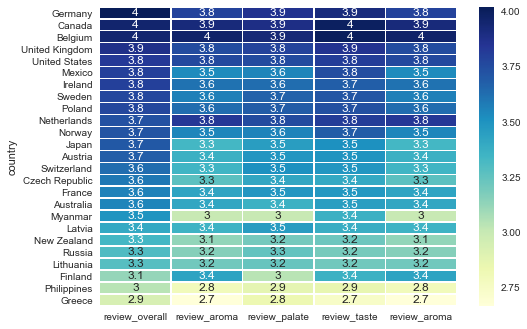

In [31]:
sn.heatmap(factors_by_country, annot=True, linewidths=.5, cmap="YlGnBu")

## Overall, the best beers are from Belgium, Canada and Germany. Belgium is also leading in each individual factor. 

## Are the most commonly reviewed beer styles good or bad?

In [32]:
## those are the most commonly reviewed beer styles 
a = combined['beer_style'].value_counts().head()
b = a.index
b

Index(['American IPA', 'American Double / Imperial IPA', 'American Strong Ale',
       'Belgian Strong Dark Ale', 'American Amber / Red Ale'],
      dtype='object')

In [33]:
only_common_styles = combined[combined['beer_style'].isin(b)]
only_common_styles.shape

(103572, 28)

In [34]:
only_common = only_common_styles.groupby('beer_style').agg(np.mean)

In [35]:
only_common.describe()[1:2]

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,aroma_appear
mean,2336.88,1231775987.34,3.95,3.95,4.02,3.92,3.99,8.07,23096.57,3.99


In [36]:
#### So, these are the means for the most commonly reviewed beer styles. 
##### let's compare them to the general means: 

combined.describe()[1:2]

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,aroma_appear
mean,2589.65,1226133706.05,3.84,3.77,3.87,3.77,3.83,7.10,22067.35,3.82


## The 5 most commonly reviewed beer styles are liked more - they score higher on all of the factors and on the overall review score.

## A last question - what would be the score for a beer with X abv %?

In [37]:
## let's drop the NaN's first: 

combined.dropna(subset = ['beer_abv'], inplace=True)
combined['beer_abv'].isnull().sum()

0

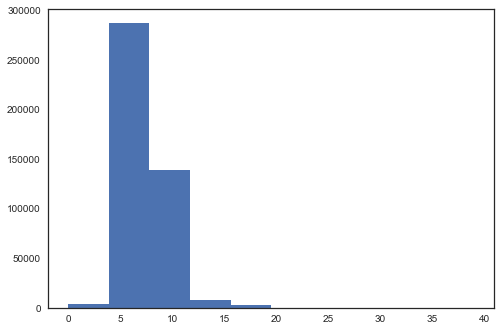

In [38]:
## what's the distibution of ABV? 
plt.hist(combined['beer_abv'])
plt.show()

In [39]:
##let's group by ABV
abv_group = combined.groupby('beer_abv').agg(np.mean)
abv_group.head(10)

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_beerid,aroma_appear
beer_abv,,,,,,,,,
0.01,187.00,1239875188.50,3.75,3.00,4.25,3.25,3.25,48553.00,3.62
0.05,103.33,1171837539.67,3.17,2.67,3.17,2.83,2.50,32906.67,2.92
0.40,440.91,1171792128.59,2.64,2.25,2.75,2.50,2.31,7799.12,2.50
0.50,119.34,1194114108.20,2.52,2.35,2.74,2.43,2.38,6902.21,2.55
0.70,2222.00,1225976623.67,2.83,3.33,3.50,3.17,2.83,29398.00,3.42
0.90,1498.00,1303496440.00,3.50,3.00,3.50,3.00,4.00,11585.00,3.25
1.20,401.00,1297868545.93,2.43,3.07,3.47,2.60,2.90,59575.00,3.27
1.25,3456.00,1141836382.00,2.50,3.50,3.50,2.00,2.00,28840.00,3.50
1.30,436.00,1145352608.00,4.50,4.50,4.00,3.50,4.00,30019.00,4.25


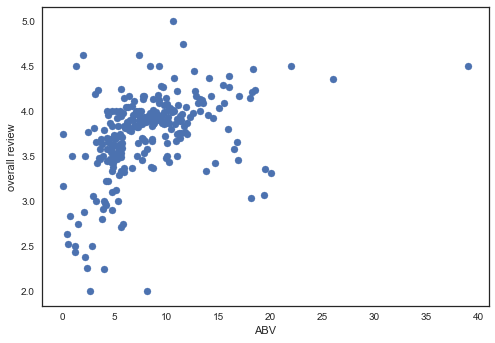

In [40]:
plt.scatter(abv_group.index, abv_group['review_overall'])
plt.xlabel('ABV')
plt.ylabel('overall review')


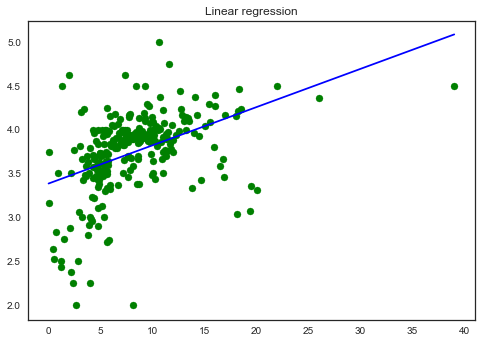

Mean Squared Error is 0.173045413262
explained_variance is 0.191346908212


In [41]:
from sklearn import linear_model

x = abv_group.index.values.reshape(263,1)
y = abv_group.review_overall.values.reshape(263, 1)
lin_reg = linear_model.LinearRegression()

lin_reg.fit(x, y)
plt.figure()
plt.scatter(x, y, color="green") ### scatter plot
y_pred = lin_reg.predict(x)
plt.plot(x, y_pred, c="blue") ##### PLOT THE LINE
plt.title('Linear regression')
plt.show()
import sklearn.metrics as sm

print("Mean Squared Error is " + str(sm.mean_squared_error(y, y_pred))) ### mean square error
print("explained_variance is " + str(sm.explained_variance_score(y, y_pred)))


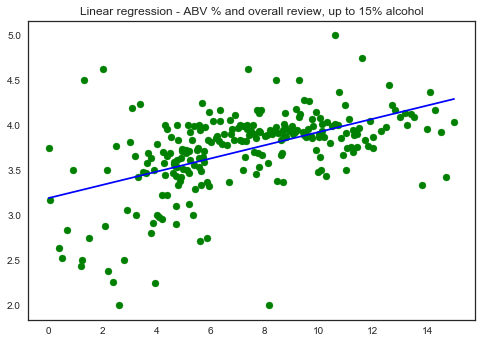

Mean Squared Error is 0.152994465683
explained_variance is 0.268109962537
correaltion and p value = (array([ 0.51779336]), array([  4.54252972e-18]))


In [42]:
### let's limit the scope of ABV to only less than 15 % 

abv15 = abv_group.loc[:15, :]
abv15.shape
### and run the regression 

x = abv15.index.values.reshape(243,1)
y = abv15.review_overall.values.reshape(243, 1)
lin_reg = linear_model.LinearRegression()

lin_reg.fit(x, y)
plt.figure()
plt.scatter(x, y, color="green") ### scatter plot
y_pred = lin_reg.predict(x)
plt.plot(x, y_pred, c="blue") ##### PLOT THE LINE
plt.title('Linear regression - ABV % and overall review, up to 15% alcohol')
plt.show()
import sklearn.metrics as sm

print("Mean Squared Error is " + str(sm.mean_squared_error(y, y_pred))) ### mean square error
print("explained_variance is " + str(sm.explained_variance_score(y, y_pred)))
print("correaltion and p value = " + str(pearsonr(x, y)))

In [43]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in l: 
    print(str(i) + "% ABV beer is predicted to have a rating of " + str(round(float(lin_reg.predict(i)[0]), 2)))

1% ABV beer is predicted to have a rating of 3.26
2% ABV beer is predicted to have a rating of 3.34
3% ABV beer is predicted to have a rating of 3.41
4% ABV beer is predicted to have a rating of 3.48
5% ABV beer is predicted to have a rating of 3.56
6% ABV beer is predicted to have a rating of 3.63
7% ABV beer is predicted to have a rating of 3.71
8% ABV beer is predicted to have a rating of 3.78
9% ABV beer is predicted to have a rating of 3.85
